# Simulation and optimization of the Qplex atom source  
  
This simulation allows to configurate and simulate the Qplex atom source, which is composed of different subparts :  
  
-An oven (here just an atomic beam)  
-A Zeeman Slower with asymmetric magnetic field  
-A 2D moving molasses  
  
This simulation also allows to compute the radial and the longitudinal temperature of the atomic beam after the whole system.  

## I - Imports


In [1]:
# - Packages
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import magpylib as magpy
from atomsmltr.environment.fields.magnetic.magpylib import MagpylibWrapper

# %matplotlib widget < disabled when building

# - atomSmltr
from atomsmltr.atoms import Ytterbium
from atomsmltr.environment.lasers import GaussianLaserBeam
from atomsmltr.environment.fields import MagneticQuadrupoleZ, MagneticOffset
from atomsmltr.environment.zones import Limits, Box
from atomsmltr.simulation import Configuration, ScipyIVP_3D
from atomsmltr.simulation.simulator import RK4
from atomsmltr.environment.lasers.polarization import CircularLeft, CircularRight, Horizontal

## II - A few functions that might help

In [2]:
# Updated function to allow specifying direction
def create_laser(tag, lasers_dict, params, direction, polarization=None):
    laser = GaussianLaserBeam(**params)
    laser.direction = np.array(direction)
    laser.tag = tag
    if polarization is not None:
        laser.polarization = polarization
    lasers_dict[tag] = laser


In [3]:
def create_laser_comb(config, detuning_min, detuning_max, frequency_gap, laser_tag, laser_dict, override):
    number_of_lasers = int((detuning_max - detuning_min) // frequency_gap) + 1
    for i in range(number_of_lasers):
        new_laser = config.get_laser_copy(laser_tag)
        new_laser.tag = f"{laser_tag}_comb_{i}"
        laser_dict[new_laser.tag] = new_laser
        config += new_laser
        config.add_atomlight_coupling(new_laser.tag, transition="main", detuning = detuning_min + i * frequency_gap, override = override)



## III - Setup and simulation of the Moving Molasses (MM)

### A - Setup of the ideal field


<Axes: title={'center': 'Field along 1D line from [ 0.    0.   -0.15] to [0.   0.   0.35]'}, xlabel='Distance along line', ylabel='Magnetic field [Bx]'>

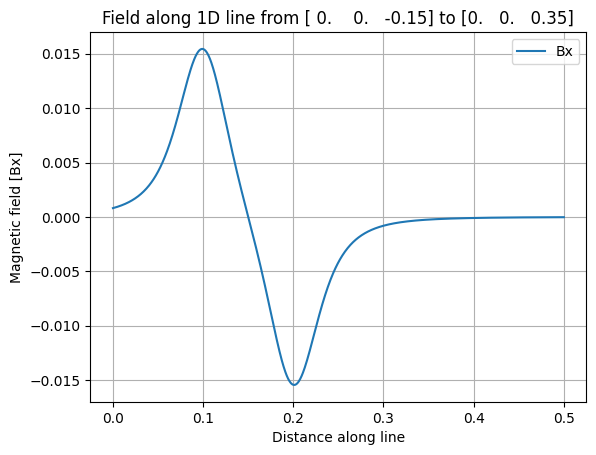

In [4]:
# -- Magnetic Field 

# - setup magnetic field: symmetric configuration of permanent magnets in Feng et a 2024
# Define magnet properties
magnetization = (-8.7e5, 0, 0)
dimension = (0.003, 0.010, 0.025)

# X positions for the cuboids (same as in your original code)
x_positions = np.linspace(-0.012, 0.012, 9)

# Create cube1 and cube2 (lists of magnets)
cube1 = [magpy.magnet.Cuboid(magnetization=magnetization, dimension=dimension) for _ in x_positions]
cube2 = [magpy.magnet.Cuboid(magnetization=magnetization, dimension=dimension) for _ in x_positions]

# Assign positions to cube1 and cube2
for i, x in enumerate(x_positions):
    cube1[i].position = (x, 0.039, -0.050)
    cube2[i].position = (x, -0.039, -0.050)

# Create cube3 and cube4 as copies of cube1 and cube2
cube3 = [c.copy() for c in cube1]
cube4 = [c.copy() for c in cube2]

# Rotate cube3 and cube4 by 180 degrees along the y-axis
for c in cube3 + cube4:
    c.rotate_from_angax(180, 'y', anchor=0)

# Combine all cubes into magnetSet as a single MagnetSet
magnetSet = magpy.Collection(cube1 + cube2 + cube3 + cube4)


# wrap it up
mag_field = MagpylibWrapper(magnetSet)
mag_field.tag = "Symmetric Permanent Magnet Configuration"

mag_field.plot1D(start=[0, 0, -0.150], stop=[0, 0, 0.350], Npoints=1000, component="Bx", space_scale=1e0)



### B - Setup of the real field 

In [5]:

# Defininition of all the cubes
cube1 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube2 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube3 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube4 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.012))

cube5 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube6 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube7 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube8 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.012))

cube9 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube10 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube11 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube12 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.012))

cube13 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube14 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube15 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube16 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.012))

cube17 = magpy.magnet.Cuboid(magnetization=(0,0,8.7*100000), dimension=(0.020,0.012,0.004))
cube18 = magpy.magnet.Cuboid(magnetization=(0,0,-8.7*100000), dimension=(0.020,0.012,0.004))

cube19 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube20 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube21 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube22 = magpy.magnet.Cuboid(magnetization=(8.7*100000,0,0), dimension=(0.004,0.012,0.020))

cube23 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube24 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube25 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.020))
cube26 = magpy.magnet.Cuboid(magnetization=(-8.7*100000,0,0), dimension=(0.004,0.012,0.020))

cube27 = magpy.magnet.Cuboid(magnetization=(0,0,8.7*100000), dimension=(0.012,0.020,0.004))
cube28 = magpy.magnet.Cuboid(magnetization=(0,0,-8.7*100000), dimension=(0.012,0.020,0.004))
cube29 = magpy.magnet.Cuboid(magnetization=(0,0,8.7*100000), dimension=(0.012,0.020,0.004))
cube30 = magpy.magnet.Cuboid(magnetization=(0,0,-8.7*100000), dimension=(0.012,0.020,0.004))

cube31 = magpy.magnet.Cuboid(magnetization=(0,0,8.7*100000), dimension=(0.012,0.020,0.004))
cube32 = magpy.magnet.Cuboid(magnetization=(0,0,-8.7*100000), dimension=(0.012,0.020,0.004))
cube33 = magpy.magnet.Cuboid(magnetization=(0,0,8.7*100000), dimension=(0.012,0.020,0.004))
cube34 = magpy.magnet.Cuboid(magnetization=(0,0,-8.7*100000), dimension=(0.012,0.020,0.004))


# Assigning position 
cube1.position = (0.034,0,-0.0475)
cube2.position = (0.034,0,-0.0875)
cube3.position = (0.034,0,-0.0675)
cube4.position = (0.030,0,-0.0675)

cube5.position = (-0.034,0,-0.0475)
cube6.position = (-0.034,0,-0.0875)
cube7.position = (-0.034,0,-0.0675)
cube8.position = (-0.030,0,-0.0675)

cube9.position = (0.034,0,0.0475)
cube10.position = (0.034,0,0.0875)
cube11.position = (0.034,0,0.0675)
cube12.position = (0.030,0,0.0675)

cube13.position = (-0.034,0,0.0475)
cube14.position = (-0.034,0,0.0875)
cube15.position = (-0.034,0,0.0675)
cube16.position = (-0.030,0,0.0675)


# the two/four magnets 17-18 give 25 G/cm @ 2D MOT
cube17.position = (-0.04,0,-0.000)
cube18.position = (0.04,0,-0.000)

cube19.position = (0.038,0,0.0675)
cube20.position = (-0.038,0,0.0675)
cube21.position = (0.042,0,0.0675)
cube22.position = (-0.042,0,0.0675)

cube23.position = (0.046,0.012,0.0975)
cube24.position = (-0.046,0.012,0.0975)
cube25.position = (0.046,-0.012,0.0975)
cube26.position = (-0.046,-0.012,0.0975)

cube27.position = (-0.09,0.055,-0.01)
cube28.position = (0.09,0.055,-0.01)
cube29.position = (-0.09,-0.055,-0.01)
cube30.position = (0.09,-0.055,-0.01)

cube31.position = (-0.09,0.08,0.001)
cube32.position = (0.09,0.08,0.001)
cube33.position = (-0.09,-0.08,0.001)
cube34.position = (0.09,-0.08,0.001)

# Add all the magnets to the field


magnetSet_asymmetric =	magpy.Collection(cube1 + cube2 + cube3 + cube4 + cube5 + cube6 + cube7 + cube8 + cube9 + cube10 + cube11 + cube12 + cube13 + cube14 + cube15 + cube16 + cube17 + cube18 + cube19 + cube20 + cube21 + cube22 + cube23 + cube24 + cube25 + cube26 + cube27 + cube28 + cube29 + cube30 + cube31 + cube32 + cube33 + cube34)
mag_field_asymmetric = MagpylibWrapper(magnetSet_asymmetric)
mag_field_asymmetric.tag = "Asymmetric Permanent Magnet Configuration"

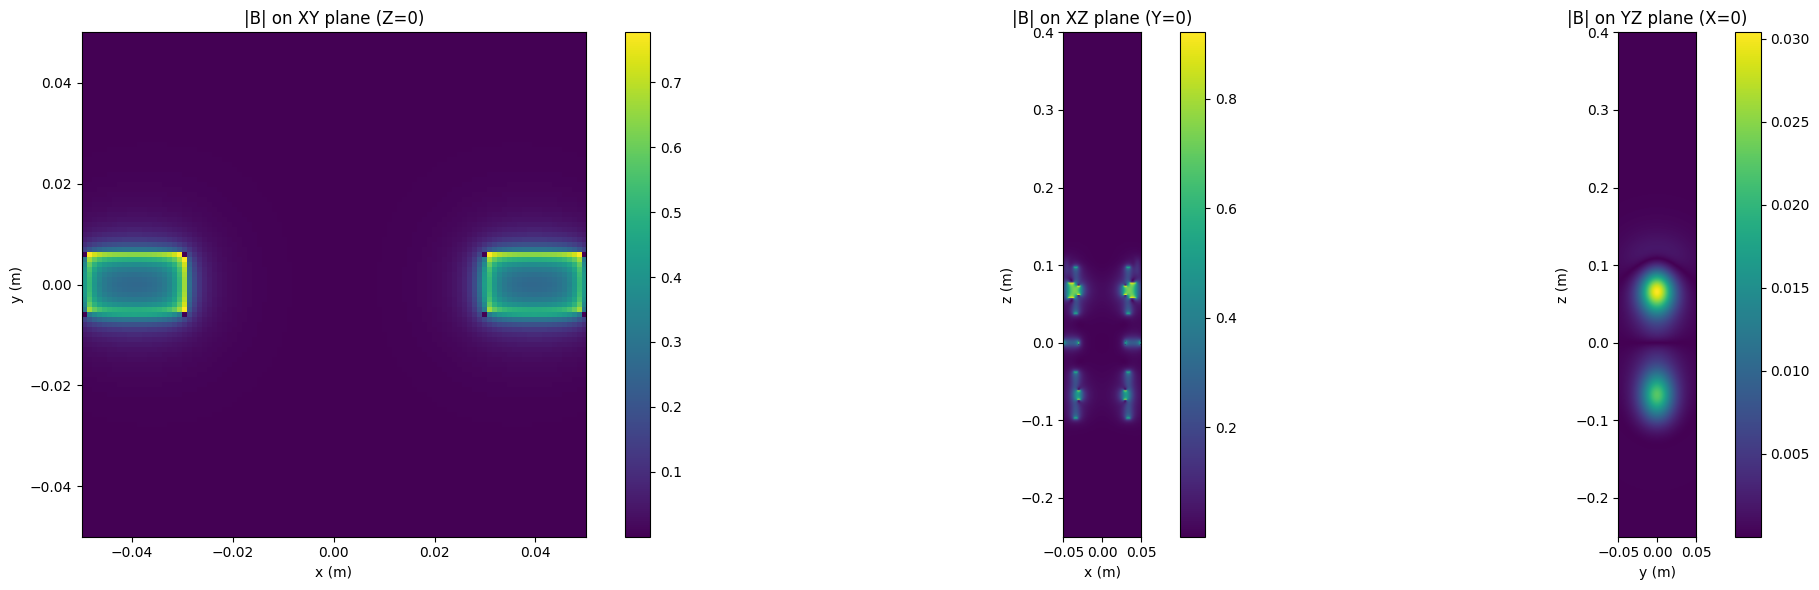

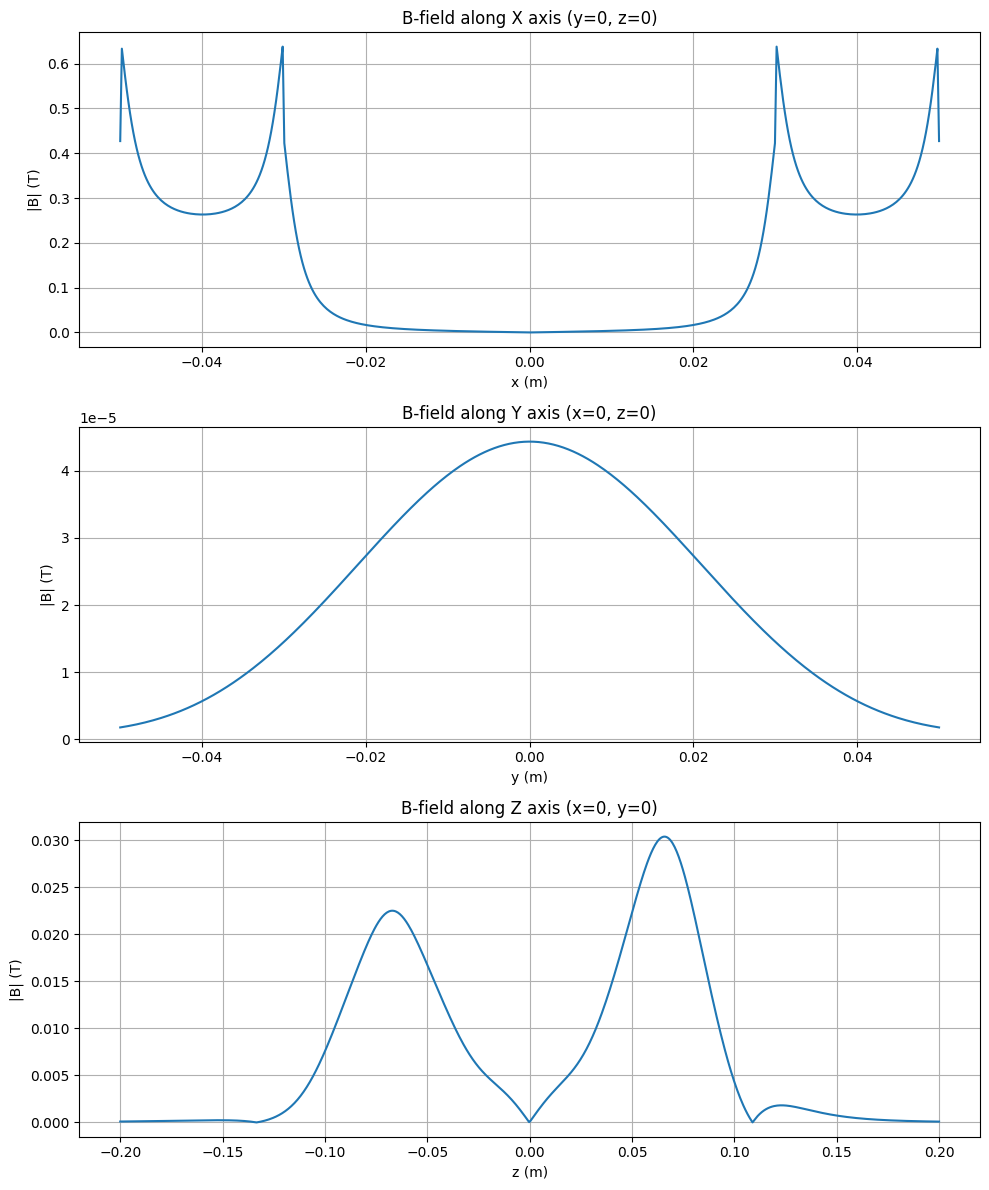

In [6]:
# ===========================================================
# 1) GRID DEFINITIONS 
# ===========================================================

tx = np.linspace(-0.050, 0.050, 101)
ty = np.linspace(-0.050, 0.050, 101)
tz = np.linspace(-0.250, 0.400, 651)

# YZ plane for X=0
gridYZ = np.array([[(0, y, z) for y in ty] for z in tz])

# XZ plane for Y=0
gridXZ = np.array([[(x, 0, z) for x in tx] for z in tz])

# XY plane for Z=0
gridXY = np.array([[(x, y, 0) for x in tx] for y in ty])


# ===========================================================
# 2) SAFE B-field evaluation
# ===========================================================

def compute_B_slice(grid):
    # Compute B-field for a (N1,N2,3) grid safely for Magpylib
    flat = grid.reshape(-1, 3)
    Bflat = magnetSet_asymmetric.getB(flat)
    return Bflat.reshape(grid.shape)   # shape (N1,N2,3)


# ===========================================================
# 3) COMPUTE 2D B-FIELDS
# ===========================================================

B_YZ = compute_B_slice(gridYZ)
B_XZ = compute_B_slice(gridXZ)
B_XY = compute_B_slice(gridXY)

Bmag_YZ = np.linalg.norm(B_YZ, axis=2)
Bmag_XZ = np.linalg.norm(B_XZ, axis=2)
Bmag_XY = np.linalg.norm(B_XY, axis=2)


# ===========================================================
# 4) PLOT 2D SLICES
# ===========================================================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ---- XY ----
im0 = axes[0].imshow(
    Bmag_XY,
    extent=[tx.min(), tx.max(), ty.min(), ty.max()],
    origin='lower',
    aspect='equal'
)
axes[0].set_title("|B| on XY plane (Z=0)")
axes[0].set_xlabel("x (m)")
axes[0].set_ylabel("y (m)")
plt.colorbar(im0, ax=axes[0])

# ---- XZ ----
im1 = axes[1].imshow(
    Bmag_XZ,
    extent=[tx.min(), tx.max(), tz.min(), tz.max()],
    origin='lower',
    aspect='equal'
)
axes[1].set_title("|B| on XZ plane (Y=0)")
axes[1].set_xlabel("x (m)")
axes[1].set_ylabel("z (m)")
plt.colorbar(im1, ax=axes[1])

# ---- YZ ----
im2 = axes[2].imshow(
    Bmag_YZ,
    extent=[ty.min(), ty.max(), tz.min(), tz.max()],
    origin='lower',
    aspect='equal'
)
axes[2].set_title("|B| on YZ plane (X=0)")
axes[2].set_xlabel("y (m)")
axes[2].set_ylabel("z (m)")
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()


# ===========================================================
# 5) 1D B-FIELD ALONG X, Y, Z AXES
# ===========================================================

# Line grids
line_x = np.linspace(-0.05, 0.05, 500)
line_y = np.linspace(-0.05, 0.05, 500)
line_z = np.linspace(-0.20, 0.20, 800)

# Build coordinate arrays
pts_x = np.column_stack([line_x, np.zeros_like(line_x), np.zeros_like(line_x)])
pts_y = np.column_stack([np.zeros_like(line_y), line_y, np.zeros_like(line_y)])
pts_z = np.column_stack([np.zeros_like(line_z), np.zeros_like(line_z), line_z])

# Evaluate
B_x = magnetSet_asymmetric.getB(pts_x)
B_y = magnetSet_asymmetric.getB(pts_y)
B_z = magnetSet_asymmetric.getB(pts_z)

# Magnitudes
Bmag_x = np.linalg.norm(B_x, axis=1)
Bmag_y = np.linalg.norm(B_y, axis=1)
Bmag_z = np.linalg.norm(B_z, axis=1)

# ===========================================================
# 6) PLOT 1D SECTIONS
# ===========================================================

fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# ---- B(x,0,0) ----
ax[0].plot(line_x, Bmag_x, label="|B|")
ax[0].set_title("B-field along X axis (y=0, z=0)")
ax[0].set_xlabel("x (m)")
ax[0].set_ylabel("|B| (T)")
ax[0].grid()

# ---- B(0,y,0) ----
ax[1].plot(line_y, Bmag_y, label="|B|")
ax[1].set_title("B-field along Y axis (x=0, z=0)")
ax[1].set_xlabel("y (m)")
ax[1].set_ylabel("|B| (T)")
ax[1].grid()

# ---- B(0,0,z) ----
ax[2].plot(line_z, Bmag_z, label="|B|")
ax[2].set_title("B-field along Z axis (x=0, y=0)")
ax[2].set_xlabel("z (m)")
ax[2].set_ylabel("|B| (T)")
ax[2].grid()

plt.tight_layout()
plt.show()


### D - Specs of the moving molasses config

In [7]:
# - setup lasers
# cf. config from Feng et al. 2024
l461_ZS = {
    "wavelength": 399e-9,
    "waist": 6.7e-3,
    "power": 225e-3,
    "waist_position": (0, 0, 0),
}



l461_2DMM = {
    "wavelength": 399e-9,
    "waist": 25e-3,
    "power": 100e-3,
    "waist_position": (0, 0, 0),
}

l461_2DMOT_B = {
    "wavelength": 399e-9,
    "waist": 10e-3,
    "power": 50e-3,
    "waist_position": (0, 0, 0),    
}

l461_2DMOT_N = {
    "wavelength": 399e-9,
    "waist": 10e-3,
    "power": 50e-3,
    "waist_position": (0, 0, 0),
}

lasers = {}
lasers_MOT = {}


In [8]:
# Define directions for 2D Moving Molasses

d1_dir = np.array([1, 1, 1]) / np.sqrt(3)
d2_dir = np.array([-1, 1, -1]) / np.sqrt(3)
d3_dir = np.array([1, -1, -1]) / np.sqrt(3)
d4_dir = np.array([-1, -1, 1]) / np.sqrt(3)

# Create Zeeman slower lasers

create_laser("ZS", lasers, l461_ZS, [0, 0, -1], Horizontal())

# Create 2D Moving Molasses lasers 

create_laser("d1>", lasers, l461_2DMM, d1_dir, CircularRight())
create_laser("d1<", lasers, l461_2DMM, d2_dir, CircularRight())
create_laser("d2>", lasers, l461_2DMM, d3_dir, CircularLeft())
create_laser("d2<", lasers, l461_2DMM, d4_dir, CircularLeft())



create_laser("2DMOT_B1>", lasers_MOT, l461_2DMOT_B, [1, 0, 0], CircularRight())
create_laser("2DMOT_B1<", lasers_MOT, l461_2DMOT_B, [-1, 0, 0], CircularLeft())
create_laser("2DMOT_B2>", lasers_MOT, l461_2DMOT_B, [0, 0, 1], CircularRight())
create_laser("2DMOT_B2<", lasers_MOT, l461_2DMOT_B, [0, 0, -1], CircularLeft())
create_laser("2DMOT_N1>", lasers_MOT, l461_2DMOT_N, [1, 0, 0], CircularLeft())
create_laser("2DMOT_N1<", lasers_MOT, l461_2DMOT_N, [-1, 0, 0], CircularRight())
create_laser("2DMOT_N2>", lasers_MOT, l461_2DMOT_N, [0, 0, 1], CircularLeft())
create_laser("2DMOT_N2<", lasers_MOT, l461_2DMOT_N, [0, 0, -1], CircularRight())

print(list(lasers_MOT.keys()))



print(list(lasers.keys()))


['2DMOT_B1>', '2DMOT_B1<', '2DMOT_B2>', '2DMOT_B2<', '2DMOT_N1>', '2DMOT_N1<', '2DMOT_N2>', '2DMOT_N2<']
['ZS', 'd1>', 'd1<', 'd2>', 'd2<']


In [9]:
# Create the Configuration
config_ytterbium = Configuration()

# Setup the atom of the configuration 
atom_ytterbium = Ytterbium()
main_ytterbium = atom_ytterbium.trans["main"]
gamma_ytterbium = main_ytterbium.Gamma

# Add the atom to the config

config_ytterbium.atom = atom_ytterbium

# Add magnetic field to the config 

config_ytterbium += mag_field

# Add limits to the config 

xlim = Limits(-0.15, 0.35, axis=0, target="position", action="stop", tag="xlim")

# Add the lasers to the config

for laser in lasers.values():
    config_ytterbium += laser

# setup atomlight
for laser in config_ytterbium.list_lasers():
    if (laser == "ZS"):
        config_ytterbium.add_atomlight_coupling(laser=laser, transition="main", detuning=-13*gamma_ytterbium)
    if (laser == "d1>") or (laser == "d1<"):
        config_ytterbium.add_atomlight_coupling(laser=laser, transition="main", detuning=-2.0*gamma_ytterbium)
    if (laser == "d2>") or (laser == "d2<"):
        config_ytterbium.add_atomlight_coupling(laser=laser, transition="main", detuning=-2.4*gamma_ytterbium)




In [10]:
"""
# Initiate simulation 
sim_ytterbium = RK4(config_ytterbium)


# Initial velocities
t = np.linspace(0, 0.1, 3000)
v_list = np.linspace(0, 550, 56)
u0_list = [(0, 0, -0.15, 0, 0, vz) for vz in v_list]

# Trajectories
coll = sim_ytterbium._integrate(u0_list, t)
coll = coll.y

"""


'\n# Initiate simulation \nsim_ytterbium = RK4(config_ytterbium)\n\n\n# Initial velocities\nt = np.linspace(0, 0.1, 3000)\nv_list = np.linspace(0, 550, 56)\nu0_list = [(0, 0, -0.15, 0, 0, vz) for vz in v_list]\n\n# Trajectories\ncoll = sim_ytterbium._integrate(u0_list, t)\ncoll = coll.y\n\n'

In [11]:
"""
# Define axes
z_axis_1  = np.linspace(-0.15, 0.35, 200)        # 200 points along z
vz_axis_1 = np.linspace(-150, 550, 351)          # 351 points along v_z

# Create 2D grid (Vz varies along rows, Z along columns)
Z_GRID_1, VZ_GRID_1 = np.meshgrid(z_axis_1, vz_axis_1)

# Build positions array for force calculation
# We assume force only depends on (0, 0, z, 0, 0, vz)
pos = np.column_stack([
    np.zeros(Z_GRID_1.size),     # x
    np.zeros(Z_GRID_1.size),     # y
    Z_GRID_1.ravel(),            # z
    np.zeros(Z_GRID_1.size),     # vx
    np.zeros(Z_GRID_1.size),     # vy
    VZ_GRID_1.ravel(),           # vz
])

# ========================================================
# 2) COMPUTE FORCE
# ========================================================

force_1= sim_ytterbium.get_force(pos)     # returns shape (N,3)
Fz_1 = force_1[:, 2].reshape(Z_GRID_1.shape)

# ========================================================
# 3) PLOT Fz(z, vz)
# ========================================================

fig_1, ax_1 = plt.subplots(figsize=(8, 6))

pcm = ax_1.pcolormesh(
    Z_GRID_1 * 100,   # convert z → cm
    VZ_GRID_1,
    Fz_1,
    cmap="bwr",
    shading="auto",
    vmin=-4.5e-19,
    vmax=4.5e-19
)

plt.colorbar(pcm, ax=ax_1, label="Fz (N)")
ax_1.set_xlabel("z (cm)")
ax_1.set_ylabel("v_z (m/s)")
ax_1.set_title("Force map Fz(z, v_z)")

plt.tight_layout()



# -- plot

index = 0
index_array = []

for res in coll:

    z = res[2]
    vz = res[5]

    # Find the index where z first reaches or exceeds 0.35
    cut_idx = np.argmax(z >= 0.35)

    # If z never reaches 0.35, plot all of it
    if z[cut_idx] < 0.35:
        mask = np.ones_like(z, dtype=bool)
    else:
        mask = np.zeros_like(z, dtype=bool)
        mask[:cut_idx] = True  # Only keep values before the threshold is crossed

    # Choose color
    if z[-1] > 0.05 or z[-1] < -0.05 or mask[-1]==False:  # Include trajectories that were cut off at z=0.35
        color = "k"
    elif np.any(z > 0.01):
        color = "C3"
        index_array.append(index)

    else:
        index_array.append(index)
        color = "C0"
    
    index += 1

    ax_1.plot(z[mask] * 100, vz[mask], color=color, linewidth=0.8)

plt.xlim(-15, 35)
plt.ylim(-150, 550)
plt.xlabel("position (cm)")
plt.ylabel("speed (m/s)")
plt.grid()
plt.show()
"""


'\n# Define axes\nz_axis_1  = np.linspace(-0.15, 0.35, 200)        # 200 points along z\nvz_axis_1 = np.linspace(-150, 550, 351)          # 351 points along v_z\n\n# Create 2D grid (Vz varies along rows, Z along columns)\nZ_GRID_1, VZ_GRID_1 = np.meshgrid(z_axis_1, vz_axis_1)\n\n# Build positions array for force calculation\n# We assume force only depends on (0, 0, z, 0, 0, vz)\npos = np.column_stack([\n    np.zeros(Z_GRID_1.size),     # x\n    np.zeros(Z_GRID_1.size),     # y\n    Z_GRID_1.ravel(),            # z\n    np.zeros(Z_GRID_1.size),     # vx\n    np.zeros(Z_GRID_1.size),     # vy\n    VZ_GRID_1.ravel(),           # vz\n])\n\n# ========================================================\n# 2) COMPUTE FORCE\n# ========================================================\n\nforce_1= sim_ytterbium.get_force(pos)     # returns shape (N,3)\nFz_1 = force_1[:, 2].reshape(Z_GRID_1.shape)\n\n# ========================================================\n# 3) PLOT Fz(z, vz)\n# ==================

In [12]:
"""
# -- Combined plot: positions and velocities vs time
fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Titles and y-axis labels
ylabels = [
    "x-position (cm)", "y-position (cm)", "z-position (cm)",
    "x-velocity (m/s)", "y-velocity (m/s)", "z-velocity (m/s)"
]

for res in coll:
    
    x = res[0] * 100           # x Position in cm
    y = res[1] * 100           # y Position in cm
    z = res[2] * 100           # z Position in cm
    vx = res[3]                # x-Velocity in m/s
    vy = res[4]                # y-Velocity in m/s
    vz = res[5]                # z-Velocity in m/s

    # Find the index where z first reaches or exceeds 35 cm or -15 cm
    cut_idx = np.argmax((z >= 35) | (z < -15))

    if (z[cut_idx] < 35) and (z[cut_idx] >= -15):
        mask = np.ones_like(z, dtype=bool)
    else:
        mask = np.zeros_like(z, dtype=bool)
        mask[:cut_idx] = True
    
    # Choose color
    if z[-1] > 5 or z[-1] < -5 or not mask[-1]:
        color = "k"
    elif np.any(z > 1):
        color = "C3"
    else:
        color = "C0"

    # Plot all six variables
    axes[0].plot(t[mask], x[mask], color=color, linewidth=0.8)
    axes[1].plot(t[mask], y[mask], color=color, linewidth=0.8)
    axes[2].plot(t[mask], z[mask], color=color, linewidth=0.8)
    axes[3].plot(t[mask], vx[mask], color=color, linewidth=0.8)
    axes[4].plot(t[mask], vy[mask], color=color, linewidth=0.8)
    axes[5].plot(t[mask], vz[mask], color=color, linewidth=0.8)

# Label and set limits
for i, (ax, ylabel) in enumerate(zip(axes, ylabels)):
    ax.set_xlim(0, 0.05)
    ax.set_xlabel("time (s)")
    ax.set_ylabel(ylabel)
    ax.grid()
    
    # Set ylim for the first 3 plots (positions)
    if i < 3:
        ax.set_ylim(-2.5, 2.5)


plt.suptitle("Trajectory Information: Position & Velocity vs Time", fontsize=16)
plt.show()
"""


'\n# -- Combined plot: positions and velocities vs time\nfig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)\n\n# Flatten axes array for easy iteration\naxes = axes.flatten()\n\n# Titles and y-axis labels\nylabels = [\n    "x-position (cm)", "y-position (cm)", "z-position (cm)",\n    "x-velocity (m/s)", "y-velocity (m/s)", "z-velocity (m/s)"\n]\n\nfor res in coll:\n\n    x = res[0] * 100           # x Position in cm\n    y = res[1] * 100           # y Position in cm\n    z = res[2] * 100           # z Position in cm\n    vx = res[3]                # x-Velocity in m/s\n    vy = res[4]                # y-Velocity in m/s\n    vz = res[5]                # z-Velocity in m/s\n\n    # Find the index where z first reaches or exceeds 35 cm or -15 cm\n    cut_idx = np.argmax((z >= 35) | (z < -15))\n\n    if (z[cut_idx] < 35) and (z[cut_idx] >= -15):\n        mask = np.ones_like(z, dtype=bool)\n    else:\n        mask = np.zeros_like(z, dtype=bool)\n        mask[:cut_idx] = T

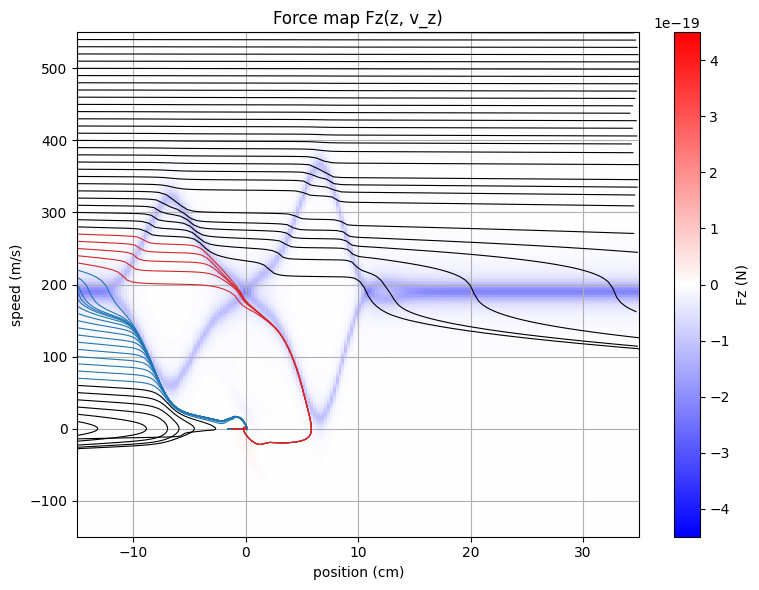

In [13]:
t = np.linspace(0, 0.1, 5000)
v_list = np.linspace(0, 550, 56)
u0_list = [(0, 0, -0.15, 0, 0, vz) for vz in v_list]

# Create the Configuration
config_ytterbium_real = Configuration()

# Add the atom to the config

config_ytterbium_real.atom = atom_ytterbium

# Add magnetic field to the config 

config_ytterbium_real += mag_field_asymmetric


# Add the lasers to the config

for laser in lasers.values():
    config_ytterbium_real += laser

for laser in lasers_MOT.values():
    config_ytterbium_real += laser

# setup atomlight
for laser in config_ytterbium_real.list_lasers():
    if (laser == "ZS"):
        config_ytterbium_real.add_atomlight_coupling(laser=laser, transition="main", detuning=-16.5*gamma_ytterbium)
    if (laser == "d1>") or (laser == "d1<"):
        config_ytterbium_real.add_atomlight_coupling(laser=laser, transition="main", detuning=-1.0*gamma_ytterbium)
    if (laser == "d2>") or (laser == "d2<"):
        config_ytterbium_real.add_atomlight_coupling(laser=laser, transition="main", detuning=-1.4*gamma_ytterbium)


# Initiate simulation 
sim_ytterbium_real = RK4(config_ytterbium_real)


# Trajectories
coll_real = sim_ytterbium_real._integrate(u0_list, t)
coll_real = coll_real.y

# ========================================================
# 1) (z, vz) GRID FOR FORCE MAPPING
# ========================================================

# Define axes
z_axis  = np.linspace(-0.15, 0.35, 200)        # 200 points along z
vz_axis = np.linspace(-150, 550, 351)          # 351 points along v_z

# Create 2D grid (Vz varies along rows, Z along columns)
Z_GRID, VZ_GRID = np.meshgrid(z_axis, vz_axis)

# Build positions array for force calculation
# We assume force only depends on (0, 0, z, 0, 0, vz)
pos = np.column_stack([
    np.zeros(Z_GRID.size),     # x
    np.zeros(Z_GRID.size),     # y
    Z_GRID.ravel(),            # z
    np.zeros(Z_GRID.size),     # vx
    np.zeros(Z_GRID.size),     # vy
    VZ_GRID.ravel(),           # vz
])

# ========================================================
# 2) COMPUTE FORCE
# ========================================================

force = sim_ytterbium_real.get_force(pos)     # returns shape (N,3)
Fz = force[:, 2].reshape(Z_GRID.shape)

# ========================================================
# 3) PLOT Fz(z, vz)
# ========================================================

fig, ax = plt.subplots(figsize=(8, 6))

pcm = ax.pcolormesh(
    Z_GRID * 100,   # convert z → cm
    VZ_GRID,
    Fz,
    cmap="bwr",
    shading="auto",
    vmin=-4.5e-19,
    vmax=4.5e-19
)

plt.colorbar(pcm, ax=ax, label="Fz (N)")
ax.set_xlabel("z (cm)")
ax.set_ylabel("v_z (m/s)")
ax.set_title("Force map Fz(z, v_z)")

plt.tight_layout()

# ========================================================
# 4) ADD TRAJECTORIES ON SAME AXES
# ========================================================

counter = 0

for res in coll_real:

    z = res[2]
    vz = res[5]

    cut_idx = np.argmax(z >= 0.35)

    if z[cut_idx] < 0.35:
        mask = np.ones_like(z, dtype=bool)
    else:
        mask = np.zeros_like(z, dtype=bool)
        mask[:cut_idx] = True

    if z[-1] > 0.05 or z[-1] < -0.05 or mask[-1] == False:
        color = "k"
    elif np.any(z > 0.01):
        color = "C3"

    else:
        color = "C0"
    
   
    ax.plot(z[mask] * 100, vz[mask], color=color, linewidth=0.8)

ax.set_xlim(-15, 35)
ax.set_ylim(-150, 550)
ax.set_xlabel("position (cm)")
ax.set_ylabel("speed (m/s)")
ax.grid()

plt.show()




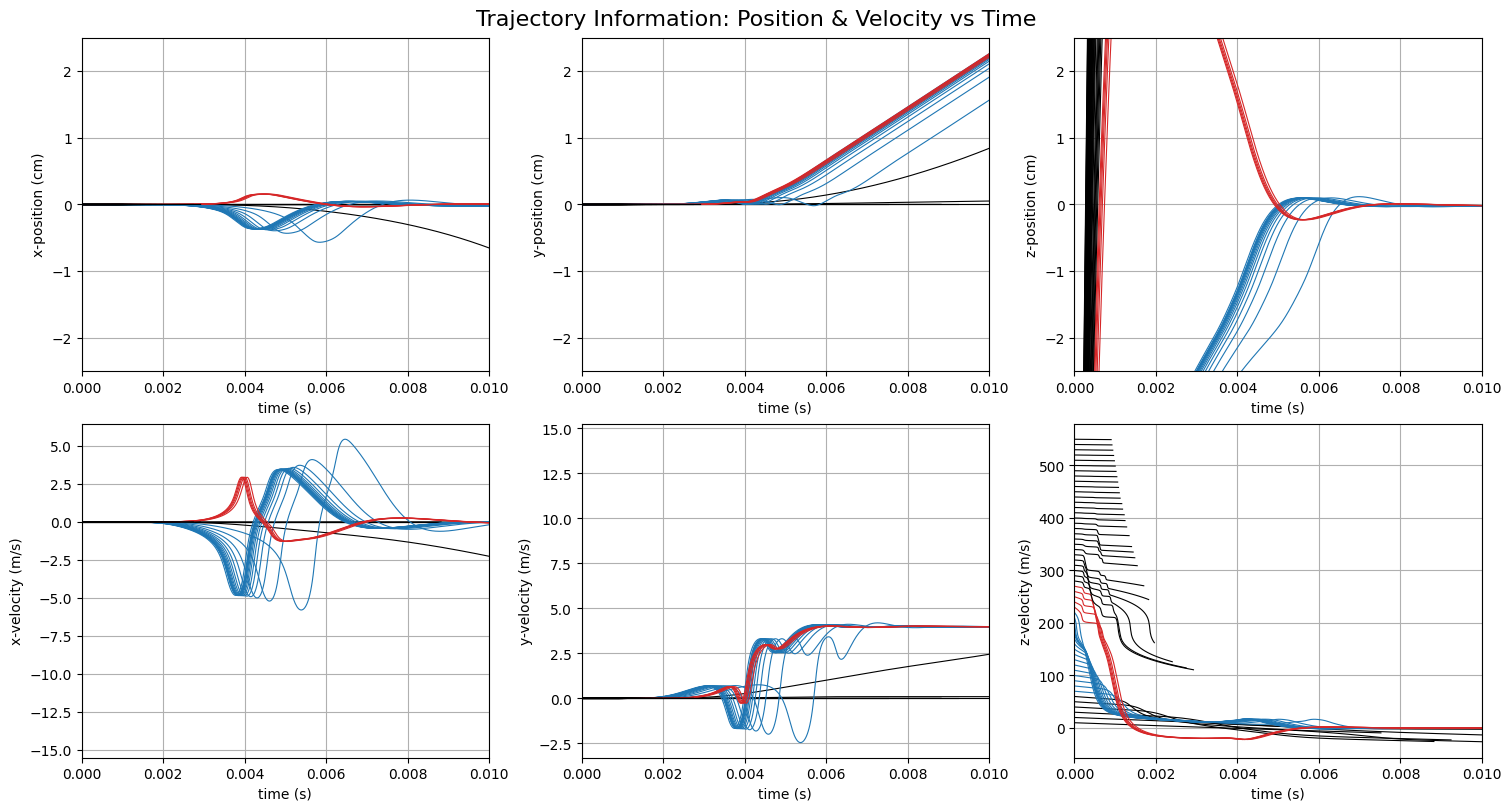

In [14]:
# -- Combined plot: positions and velocities vs time
fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Titles and y-axis labels
ylabels = [
    "x-position (cm)", "y-position (cm)", "z-position (cm)",
    "x-velocity (m/s)", "y-velocity (m/s)", "z-velocity (m/s)"
]

for res in coll_real:
    
    x = res[0] * 100           # x Position in cm
    y = res[1] * 100           # y Position in cm
    z = res[2] * 100           # z Position in cm
    vx = res[3]                # x-Velocity in m/s
    vy = res[4]                # y-Velocity in m/s
    vz = res[5]                # z-Velocity in m/s

    # Find the index where z first reaches or exceeds 35 cm or -15 cm
    cut_idx = np.argmax((z >= 35) | (z < -15))

    if (z[cut_idx] < 35) and (z[cut_idx] >= -15):
        mask = np.ones_like(z, dtype=bool)
    else:
        mask = np.zeros_like(z, dtype=bool)
        mask[:cut_idx] = True
    
    # Choose color
    if z[-1] > 5 or z[-1] < -5 or not mask[-1]:
        color = "k"
    elif np.any(z > 1):
        color = "C3"
    else:
        color = "C0"

    # Plot all six variables
    axes[0].plot(t[mask], x[mask], color=color, linewidth=0.8)
    axes[1].plot(t[mask], y[mask], color=color, linewidth=0.8)
    axes[2].plot(t[mask], z[mask], color=color, linewidth=0.8)
    axes[3].plot(t[mask], vx[mask], color=color, linewidth=0.8)
    axes[4].plot(t[mask], vy[mask], color=color, linewidth=0.8)
    axes[5].plot(t[mask], vz[mask], color=color, linewidth=0.8)

# Label and set limits
for i, (ax, ylabel) in enumerate(zip(axes, ylabels)):
    ax.set_xlim(0, 0.01)
    ax.set_xlabel("time (s)")
    ax.set_ylabel(ylabel)
    ax.grid()
    
    # Set ylim for the first 3 plots (positions)
    if i < 3:
        ax.set_ylim(-2.5, 2.5)


plt.suptitle("Trajectory Information: Position & Velocity vs Time", fontsize=16)
plt.show()





In [15]:
u1_list = coll_real[:,0:6,2999]

In [16]:
"""t_suite = np.linspace(0, 0.05, 1000)

# Initiate simulation 
sim_ytterbium_real_suite = RK4(config_ytterbium_real)


# Trajectories
coll_real_suite = sim_ytterbium_real_suite._integrate(u1_list, t_suite)
coll_real_suite = coll_real_suite.y

# -- Combined plot: positions and velocities vs time
fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Titles and y-axis labels
ylabels = [
    "x-position (cm)", "y-position (cm)", "z-position (cm)",
    "x-velocity (m/s)", "y-velocity (m/s)", "z-velocity (m/s)"
]

for res in coll_real_suite:
    
    x = res[0] * 100           # x Position in cm
    y = res[1] * 100           # y Position in cm
    z = res[2] * 100           # z Position in cm
    vx = res[3]                # x-Velocity in m/s
    vy = res[4]                # y-Velocity in m/s
    vz = res[5]                # z-Velocity in m/s



    # Plot all six variables
    axes[0].plot(t_suite, x, linewidth=0.8)
    axes[1].plot(t_suite, y, linewidth=0.8)
    axes[2].plot(t_suite, z, color=color, linewidth=0.8)
    axes[3].plot(t_suite, vx, color=color, linewidth=0.8)
    axes[4].plot(t_suite, vy, color=color, linewidth=0.8)
    axes[5].plot(t_suite, vz, color=color, linewidth=0.8)



plt.suptitle("Trajectory Information: Position & Velocity vs Time", fontsize=16)
plt.show()"""

't_suite = np.linspace(0, 0.05, 1000)\n\n# Initiate simulation \nsim_ytterbium_real_suite = RK4(config_ytterbium_real)\n\n\n# Trajectories\ncoll_real_suite = sim_ytterbium_real_suite._integrate(u1_list, t_suite)\ncoll_real_suite = coll_real_suite.y\n\n# -- Combined plot: positions and velocities vs time\nfig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)\n\n# Flatten axes array for easy iteration\naxes = axes.flatten()\n\n# Titles and y-axis labels\nylabels = [\n    "x-position (cm)", "y-position (cm)", "z-position (cm)",\n    "x-velocity (m/s)", "y-velocity (m/s)", "z-velocity (m/s)"\n]\n\nfor res in coll_real_suite:\n\n    x = res[0] * 100           # x Position in cm\n    y = res[1] * 100           # y Position in cm\n    z = res[2] * 100           # z Position in cm\n    vx = res[3]                # x-Velocity in m/s\n    vy = res[4]                # y-Velocity in m/s\n    vz = res[5]                # z-Velocity in m/s\n\n\n\n    # Plot all six variables\n    